In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import joblib
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [58]:
df = pd.read_csv('../data/Bronze/salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


In [59]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [60]:
df = df[df['job_title'] == 'Data Scientist'].reset_index(drop=True)


In [61]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M
1,2025,SE,FT,Data Scientist,197000,USD,197000,US,0,US,M
2,2025,SE,FT,Data Scientist,349000,USD,349000,US,0,US,M
3,2025,SE,FT,Data Scientist,248000,USD,248000,US,0,US,M
4,2025,SE,FT,Data Scientist,279400,USD,279400,US,100,US,M


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17934 entries, 0 to 17933
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           17934 non-null  int64 
 1   experience_level    17934 non-null  object
 2   employment_type     17934 non-null  object
 3   job_title           17934 non-null  object
 4   salary              17934 non-null  int64 
 5   salary_currency     17934 non-null  object
 6   salary_in_usd       17934 non-null  int64 
 7   employee_residence  17934 non-null  object
 8   remote_ratio        17934 non-null  int64 
 9   company_location    17934 non-null  object
 10  company_size        17934 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.5+ MB


In [63]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Drop irrelevant columns

In [64]:
df = df.drop(columns=['job_title', 'salary', 'salary_currency'])
df = df.dropna()

In [65]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

['experience_level', 'employment_type', 'employee_residence', 'company_location', 'company_size']


In [66]:
for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_vals)
    print()

Unique values in 'experience_level':
['SE' 'MI' 'EN' 'EX']

Unique values in 'employment_type':
['FT' 'PT' 'CT' 'FL']

Unique values in 'employee_residence':
['US' 'CA' 'GB' 'DE' 'NL' 'AT' 'AU' 'FR' 'IE' 'LT' 'PL' 'ES' 'IN' 'SK'
 'SE' 'MX' 'SG' 'NZ' 'KR' 'TR' 'BG' 'BR' 'HU' 'TW' 'BE' 'IT' 'LV' 'EG'
 'JP' 'CH' 'FI' 'AR' 'CL' 'PT' 'KE' 'ZA' 'EE' 'UA' 'RO' 'PK' 'GR' 'PH'
 'AD' 'EC' 'NO' 'UZ' 'HK' 'TH' 'CY' 'DO' 'RU' 'DZ' 'NG' 'RS']

Unique values in 'company_location':
['US' 'CA' 'GB' 'DE' 'NL' 'AT' 'AU' 'FR' 'IE' 'LT' 'PL' 'ES' 'IN' 'SK'
 'SE' 'MX' 'SG' 'NZ' 'KR' 'TR' 'BG' 'BR' 'HU' 'TW' 'BE' 'IT' 'LV' 'EG'
 'JP' 'CH' 'FI' 'AR' 'CL' 'PT' 'KE' 'GR' 'ZA' 'EE' 'UA' 'RO' 'LU' 'CZ'
 'AD' 'EC' 'NO' 'HK' 'RU' 'TH' 'ID' 'MY' 'DZ' 'NG' 'IL']

Unique values in 'company_size':
['M' 'L' 'S']



In [67]:
exp_map = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
size_map = {'S': 0, 'M': 1, 'L': 2}

In [68]:
df['experience_level'] = df['experience_level'].map(exp_map)
df['company_size'] = df['company_size'].map(size_map)

In [69]:
one_hot_cols = ['employment_type', 'employee_residence', 'company_location']

df = pd.get_dummies(df, columns=one_hot_cols, prefix=one_hot_cols)

In [70]:
df.head()

,work_year,experience_level,salary_in_usd,remote_ratio,company_size,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,employee_residence_AD,employee_residence_AR,employee_residence_AT,employee_residence_AU,employee_residence_BE,employee_residence_BG,employee_residence_BR,employee_residence_CA,employee_residence_CH,employee_residence_CL,employee_residence_CY,employee_residence_DE,employee_residence_DO,employee_residence_DZ,employee_residence_EC,employee_residence_EE,employee_residence_EG,employee_residence_ES,employee_residence_FI,employee_residence_FR,employee_residence_GB,employee_residence_GR,employee_residence_HK,employee_residence_HU,employee_residence_IE,employee_residence_IN,employee_residence_IT,employee_residence_JP,employee_residence_KE,employee_residence_KR,employee_residence_LT,employee_residence_LV,employee_residence_MX,employee_residence_NG,employee_residence_NL,employee_residence_NO,employee_residence_NZ,employee_residence_PH,employee_residence_PK,employee_residence_PL,employee_residence_PT,employee_residence_RO,employee_residence_RS,employee_residence_RU,employee_residence_SE,employee_residence_SG,employee_residence_SK,employee_residence_TH,employee_residence_TR,employee_residence_TW,employee_residence_UA,employee_residence_US,employee_residence_UZ,employee_residence_ZA,company_location_AD,company_location_AR,company_location_AT,company_location_AU,company_location_BE,company_location_BG,company_location_BR,company_location_CA,company_location_CH,company_location_CL,company_location_CZ,company_location_DE,company_location_DZ,company_location_EC,company_location_EE,company_location_EG,company_location_ES,company_location_FI,company_location_FR,company_location_GB,company_location_GR,company_location_HK,company_location_HU,company_location_ID,company_location_IE,company_location_IL,company_location_IN,company_location_IT,company_location_JP,company_location_KE,company_location_KR,company_location_LT,company_location_LU,company_location_LV,company_location_MX,company_location_MY,company_location_NG,company_location_NL,company_location_NO,company_location_NZ,company_location_PL,company_location_PT,company_location_RO,company_location_RU,company_location_SE,company_location_SG,company_location_SK,company_location_TH,company_location_TR,company_location_TW,company_location_UA,company_location_US,company_location_ZA
0,2025,2,291000,0,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,2025,2,197000,0,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,2025,2,349000,0,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [71]:
df.shape

(17934, 116)

In [72]:
X = df.drop('salary_in_usd', axis=1)  
y = df['salary_in_usd']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14347, 115), (3587, 115), (14347,), (3587,))

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17934 entries, 0 to 17933
Columns: 116 entries, work_year to company_location_ZA
dtypes: bool(111), int64(5)
memory usage: 2.6 MB


Training

In [76]:
model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}



# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
print("✅ Best parameters:", grid_search.best_params_)
print("🔢 Best score (negative MSE):", grid_search.best_score_)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
✅ Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
🔢 Best score (negative MSE): -3453780531.2


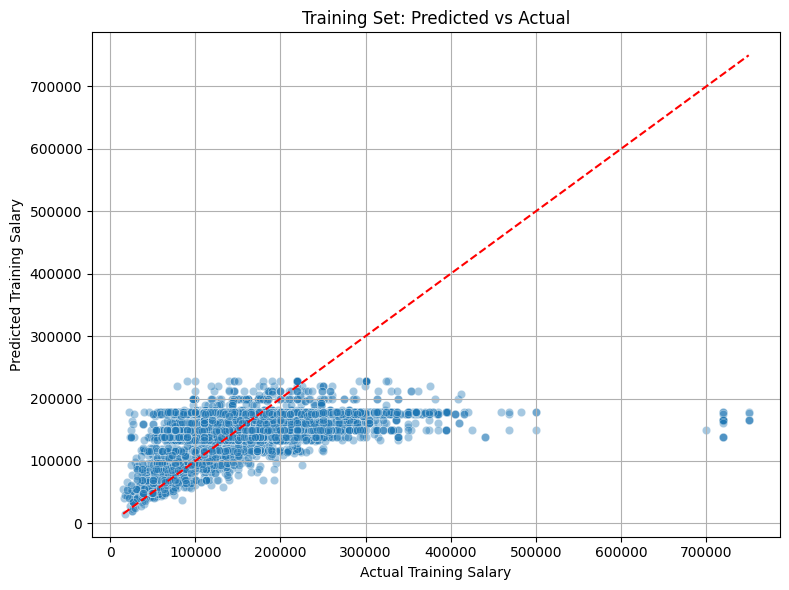

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on training set
# model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # ideal line
plt.xlabel("Actual Training Salary")
plt.ylabel("Predicted Training Salary")
plt.title("Training Set: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

Test MSE: 3488087296.0000
Test RMSE: 59060.0313
Test R²: 0.1810
